# Supp Figure 4 - SWMT for all densities

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.colors as col
import matplotlib.path as mpath
import xarray as xr
import cmocean.cm as cmocean
import glob

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/easterlies/paper_figures/'

In [2]:
#client = Client(n_workers=4)
# >> dask-scheduler
# >> dask-worker tcp://10.0.64.9:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157
#client = Client('tcp://10.0.64.9:8786', local_dir='/local/g40/amh157')
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 125.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35847,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 125.20 GiB
Comm: tcp://127.0.0.1:35705,Total threads: 4
Dashboard: /proxy/37947/status,Memory: 17.89 GiB
Nanny: tcp://127.0.0.1:44107,


In [3]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'

# 3 year average: ?

start_time='2155-01-01'
end_time='2159-12-31'

lat_slice  = slice(-80,-50)
lon_slice  = slice(-280, 80)

In [4]:
# main easterlies experiments
session_name = '/g/data/v45/akm157/model_data/access-om2/01deg_jra55v13_ryf9091_easterlies_up10/easterlies.db'
easterlies_session = cc.database.create_session(session_name)

easterlies_up = '01deg_jra55v13_ryf9091_easterlies_up10'
easterlies_down = '01deg_jra55v13_ryf9091_easterlies_down10'
easterlies_up_noDSW = '01deg_jra55v13_ryf9091_easterlies_up10_noDSW'

In [7]:
# topography data:
ht = cc.querying.getvar(control,'ht' , master_session,n=1)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)

# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90
fontsize=16

## Load prepocessed SWMT:

In [5]:
start_time='2150-01-01'
end_time='2159-12-31'
time_period = str(int(start_time[:4]))+'-'+str(int(end_time[:4]))

# stitch together west and east sections:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_control_west = output.net_transformation_control
outpath = '/g/data/v45/akm157/model_data/access-om2/'+control+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_control_east = output.net_transformation_control
net_transformation_control = xr.concat([net_transformation_control_west,net_transformation_control_east],dim='xt_ocean')

# Note that I forgot to change the names of these variables when I saved them, but despite that they are for the correct simulations:
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_east = output.net_transformation_up1
net_transformation_up = xr.concat([net_transformation_up_west,net_transformation_up_east],dim='xt_ocean')

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_down_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_down+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_down_east = output.net_transformation_up1
net_transformation_down = xr.concat([net_transformation_down_west,net_transformation_down_east],dim='xt_ocean')

outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/west_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_noDSW_west = output.net_transformation_up1
outpath = '/g/data/v45/akm157/model_data/access-om2/'+easterlies_up_noDSW+'/SWMT/east_shelf_transformation_sigma0_'+time_period+'_finer_bins.nc'
output = xr.open_dataset(outpath)
net_transformation_up_noDSW_east = output.net_transformation_up1
net_transformation_up_noDSW = xr.concat([net_transformation_up_noDSW_west,net_transformation_up_noDSW_east],dim='xt_ocean')

## Make masks for different regions (use same masks as in Figure 1):

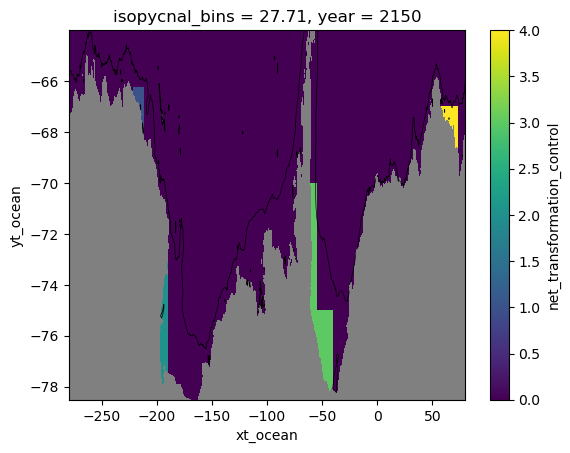

In [8]:
# set up empty masks:
Ross_mask = net_transformation_control[0,0,...]*0+1
Ross_mask = Ross_mask.fillna(1)

Adelie_mask = Ross_mask.copy()
Weddell_mask = Ross_mask.copy()
Prydz_mask = Ross_mask.copy()

yt_ocean = Ross_mask.yt_ocean
xt_ocean = Ross_mask.xt_ocean

# set regions:
Ross_mask = Ross_mask.where(yt_ocean<-72).where(yt_ocean>-79).where(xt_ocean>161.5-360).where(xt_ocean<170-360)

Prydz_mask = Prydz_mask.where(yt_ocean<-67).where(yt_ocean>-69).where(xt_ocean>58).where(xt_ocean<73)

Adelie_mask = Adelie_mask.where(yt_ocean<-66.2).where(yt_ocean>-69).where(xt_ocean>138-360).where(xt_ocean<148-360)

# two area to include for this one:
Weddell_maskW = Weddell_mask.where(yt_ocean<-70).where(yt_ocean>-79).where(xt_ocean>297-360).where(xt_ocean<305-360)
Weddell_maskE = Weddell_mask.where(yt_ocean<-75).where(yt_ocean>-79).where(xt_ocean>305-360).where(xt_ocean<320-360)
Weddell_mask = Weddell_maskE.fillna(0) + Weddell_maskW.fillna(0)
Weddell_mask = Weddell_mask.where(Weddell_mask == 1)

#Weddell_mask.plot()
#plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
#plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

### note region order:
# regions = ['Adelie','Ross','Weddell','Prydz']

# combine all masks:
combined_mask = Adelie_mask.fillna(0) + Ross_mask.fillna(0)*2 + Weddell_mask.fillna(0)*3 + Prydz_mask.fillna(0)*4

combined_mask.plot()
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000],linewidths=0.5,colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')

Max swmt = 1.2598360126967802
Max swmt = 2.0272487456591484
Max swmt = 2.284753046178565
Max swmt = 2.0733570932732905


array([27.83, 28.03, 27.81, 27.79])

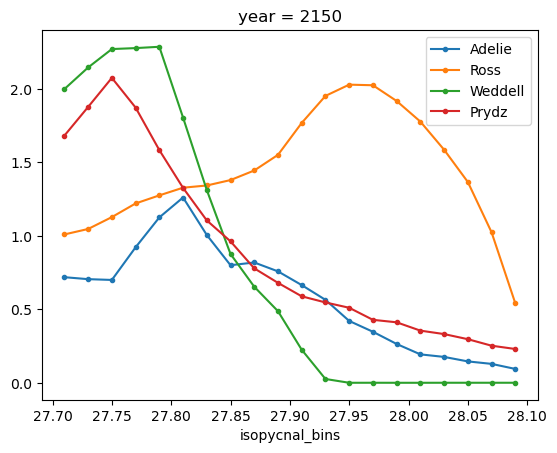

In [22]:
## Find density thresholds to use for each region using a 10 year average of the control:

time_slice = slice(2150,2159)
control_transformation_mean = net_transformation_control.sel(year=time_slice).mean('year')

area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

regions = ['Adelie','Ross','Weddell','Prydz']
density_threshold = np.zeros(4)

# use density where SWMT is 70% of peak value:
percent_max_SWMT = 0.7

for DSW_region_count in range(4):
    region = regions[DSW_region_count]
    area_mask = area_t.where(combined_mask == DSW_region_count + 1)
    swmt_sum_region = ((control_transformation_mean*area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6).compute()
    swmt_sum_region.plot(marker='.',label=region)
    # find max value:
    swmt_max = swmt_sum_region.max().values
    print('Max swmt = '+str(swmt_max))
    # find density where swmt = 0.7*swmt_max:
    density_threshold[DSW_region_count] = swmt_sum_region.where(swmt_sum_region >= swmt_max*percent_max_SWMT,drop=True)[-1].isopycnal_bins.values
    
plt.legend()

density_threshold

Note the Ross SWMT is really dense here, I think that's because it's a very small region right in the western side of the Ross Sea.

### Time average plots:

In [18]:
# average over the 5 years: 
time_slice = slice(2155,2159)

area_t = cc.querying.getvar(control, 'area_t', master_session, n=1)

def plot_time_avg_SWMT(DSW_region_count):
    # select area just for this DSW region:
    
    region = regions[DSW_region_count]
    area_mask = area_t.where(combined_mask == DSW_region_count + 1)
        
    swmt_sum_control = ((net_transformation_control.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_up = ((net_transformation_up.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_down = ((net_transformation_down.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    swmt_sum_up_noDSW = ((net_transformation_up_noDSW.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    #swmt_sum_up_zonal = ((net_transformation_zonal.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    #swmt_sum_up_meridional = ((net_transformation_meridional.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
    
    plt.plot(swmt_sum_control,swmt_sum_control.isopycnal_bins, 'k',linewidth=1,label='CONTROL')
    plt.plot(swmt_sum_up,swmt_sum_up.isopycnal_bins,label='WIND+')
    plt.plot(swmt_sum_down,swmt_sum_down.isopycnal_bins,label='WIND-')
    plt.plot(swmt_sum_up_noDSW,swmt_sum_up_noDSW.isopycnal_bins,label=r'WIND+$_{no_local}$',color='C4')
    #plt.plot(swmt_sum_up_zonal,swmt_sum_up_zonal.isopycnal_bins, '.',label='Up zonal')
    #plt.plot(swmt_sum_up_meridional,swmt_sum_up_meridional.isopycnal_bins,'.', label='Up meridional')
    plt.ylim((28.1, 27.7))
    plt.ylabel(r'$\sigma_{0}$ (kg m$^{-3}$)', fontsize = fontsize)
    plt.xlabel('Surface water mass transformation (Sv)', fontsize=fontsize)
    plt.legend(loc=2, fontsize = fontsize);
    plt.tick_params(labelsize=fontsize)
    plt.title(region+' SWMT, years 2155-2159', fontsize=fontsize);
    
    plt.plot([0,2],[density_threshold[DSW_region_count],density_threshold[DSW_region_count]],linestyle='--',color='grey')


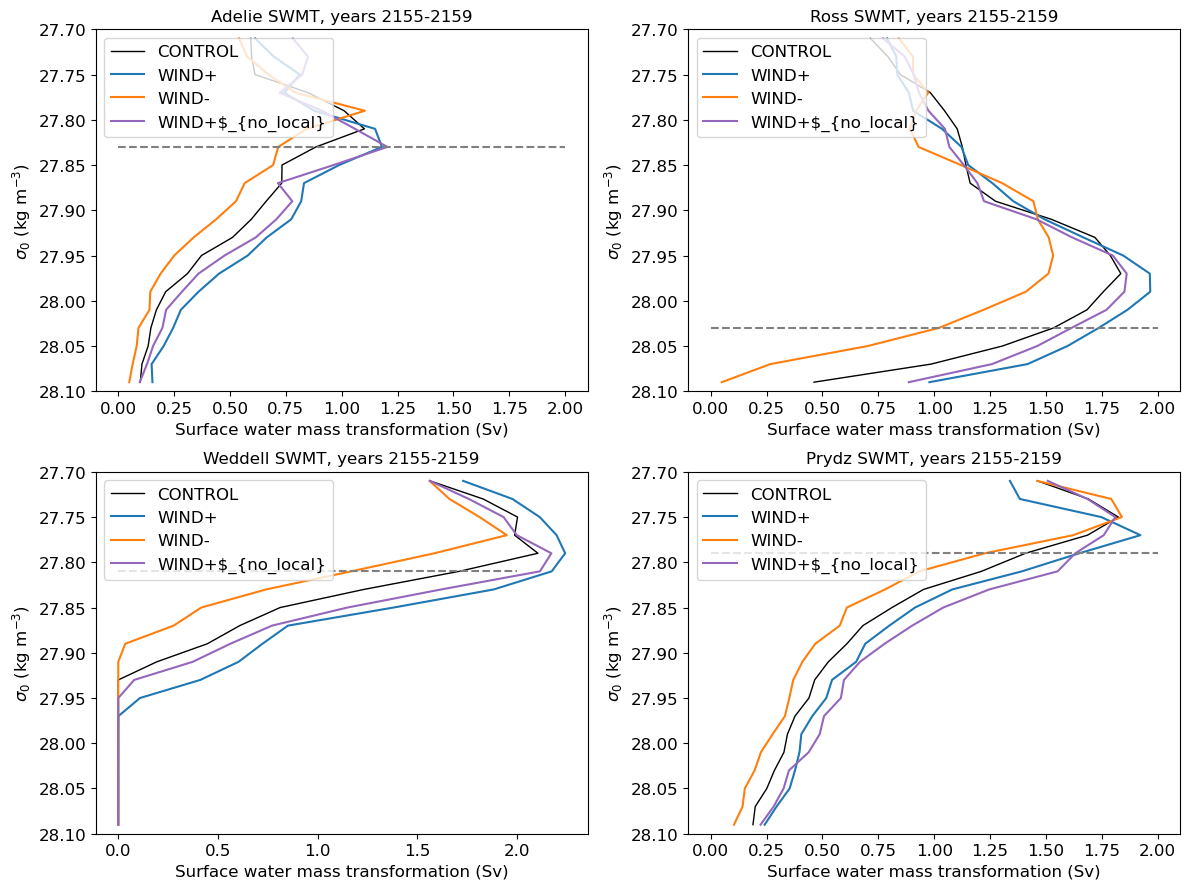

In [19]:
fontsize = 12
fig = plt.figure(num=1, figsize = (12, 9))

plt.subplot(2,2,1)
plot_time_avg_SWMT(0)

plt.subplot(2,2,2)
plot_time_avg_SWMT(1)

plt.subplot(2,2,3)
plot_time_avg_SWMT(2)

plt.subplot(2,2,4)
plot_time_avg_SWMT(3)

plt.tight_layout()

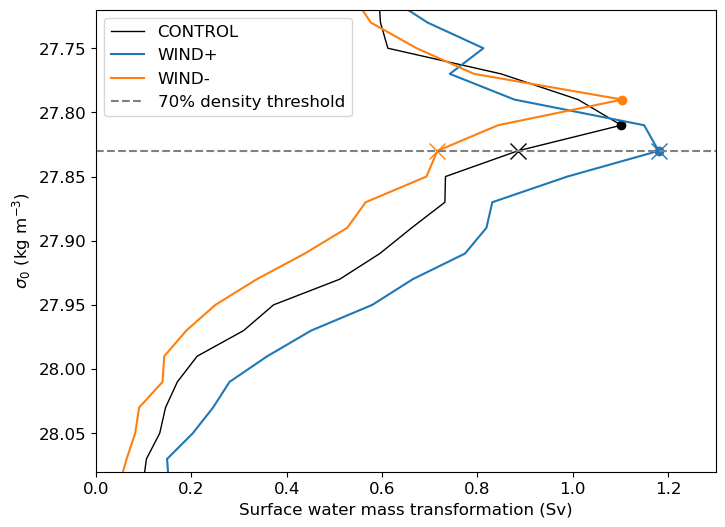

In [51]:
fontsize = 12
fig = plt.figure(num=1, figsize = (8,6))

time_slice = slice(2155,2159)

DSW_region_count = 0
region = regions[DSW_region_count]
area_mask = area_t.where(combined_mask == DSW_region_count + 1)

swmt_sum_control = (((net_transformation_control.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6).compute()
swmt_sum_up = (((net_transformation_up.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6).compute()
swmt_sum_down = (((net_transformation_down.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6).compute()
#swmt_sum_up_noDSW = ((net_transformation_up_noDSW.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
#swmt_sum_up_zonal = ((net_transformation_zonal.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6
#swmt_sum_up_meridional = ((net_transformation_meridional.sel(year=time_slice).mean('year'))* area_mask).sum(['xt_ocean', 'yt_ocean'])/1e6

# plot max marker values:
# control max:
value = swmt_sum_control.max().values
density = swmt_sum_control.where(swmt_sum_control == value,drop=True)[-1].isopycnal_bins.values
plt.plot([value],[density],marker='o',color='k')
# UP max:
value = swmt_sum_up.max().values
density = swmt_sum_up.where(swmt_sum_up == value,drop=True)[-1].isopycnal_bins.values
plt.plot([value],[density],marker='o',color='C0')
# DOWN max:
value = swmt_sum_down.max().values
density = swmt_sum_down.where(swmt_sum_down == value,drop=True)[-1].isopycnal_bins.values
plt.plot([value],[density],marker='o',color='C1')
# 70%:
plt.plot([swmt_sum_control.sel(isopycnal_bins=density_threshold[DSW_region_count])],[density_threshold[DSW_region_count]],
         marker='x',color='k',markersize=12)
plt.plot([swmt_sum_up.sel(isopycnal_bins=density_threshold[DSW_region_count])],[density_threshold[DSW_region_count]],
         marker='x',color='C0',markersize=12)
plt.plot([swmt_sum_down.sel(isopycnal_bins=density_threshold[DSW_region_count])],[density_threshold[DSW_region_count]],
         marker='x',color='C1',markersize=12)

plt.plot(swmt_sum_control,swmt_sum_control.isopycnal_bins, 'k',linewidth=1,label='CONTROL')
plt.plot(swmt_sum_up,swmt_sum_up.isopycnal_bins,label='WIND+')
plt.plot(swmt_sum_down,swmt_sum_down.isopycnal_bins,label='WIND-')
#plt.plot(swmt_sum_up_noDSW,swmt_sum_up_noDSW.isopycnal_bins,label=r'WIND+$_{no_local}$',color='C4')
#plt.plot(swmt_sum_up_zonal,swmt_sum_up_zonal.isopycnal_bins, '.',label='Up zonal')
#plt.plot(swmt_sum_up_meridional,swmt_sum_up_meridional.isopycnal_bins,'.', label='Up meridional')
plt.ylim((28.08, 27.72))
plt.ylabel(r'$\sigma_{0}$ (kg m$^{-3}$)', fontsize = fontsize)
plt.xlabel('Surface water mass transformation (Sv)', fontsize=fontsize)

plt.tick_params(labelsize=fontsize)
#plt.title(region+' Surface watermass transformation', fontsize=fontsize);

plt.plot([0,1.5],[density_threshold[DSW_region_count],density_threshold[DSW_region_count]],linestyle='--',color='grey',
         label='70% density threshold')

plt.legend(loc=2, fontsize = fontsize);
plt.xlim(0,1.3)
         
figure_path = figdir+'SuppFig4_SWMT_method.pdf'
fig.savefig(figure_path, dpi=120,bbox_inches='tight', pad_inches=0.1)